# TCW Recession and Phenology plots notebook

- This notebook uses surface reflectance and pq for a polygon area
- Calculates TCW, then slope of TCW for dry months (averaged yearly) and p-values for slopes
- Creates phenology plots of TCW

- _Requires_: a shapefile, and some paths to be changed in order to save the plots and pickle files to somewhere you have access to.
- Written in python 3.6.3 using DEA module /agdc-py3-prod/1.5.3

##### Bex Dunn, Neil Symington, Vanessa Newey, Leo Lymburner Nov 2017

## Load modules

In [1]:
from scipy import stats
%matplotlib inline

#----from NB1----#
#get some libraries
import datacube

import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#use pickle for saving data to file
import pickle

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

from IPython.display import display
import ipywidgets as widgets

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

## Function definitions : load and mask surface reflectance

In [2]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [3]:
#calculating tasselled cap wetness for all sensors
def calc_wetness(sensor_data):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 19-10-2017 bd updated 16-11-17 to use one set of coefficients
    and not specify which sensor as the coefficients are based on the processed nbart'''

    wetness_coeff = {'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511}
                    
    if sensor_data is not None: 
         # make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness')
        return wbg    
    else:
        print('did not calculate wetness')
        return None            

In [4]:
def calc_wetness_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            wetness['wetness_over_threshold'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness over threshold' )
        return None    

In [5]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.wetness_over_threshold.count(dim='time')
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

### Bring in a shape file

In [6]:
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/mitchell_2.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
#choose the index of the polygon you want within the shape file
i =0
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
print(shape_name)

mitchell_2_0


### set up datacube query

In [7]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-nbart')

In [8]:
#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

In [9]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [10]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

### load in surface reflectance data for polygon 

In [11]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
did not load ls5_nbart_albers
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### concatenate sensor data

In [12]:
#make an array of all the clean sensor data
sensor_list = []
for sensor in [sensor1_nbart, sensor2_nbart, sensor3_nbart]:
    if sensor is not None:
        sensor_list.append(sensor)
nbart_allsensors = xr.concat(sensor_list,dim='time')
#steal affine for use in transforming image coords later on
affine = nbart_allsensors.affine

In [13]:
# del sensor1_nbart
# del sensor2_nbart
# del sensor3_nbart
# del sensor_list

In [16]:
# could be done this way too!
# sensor_list = [load_nbart(sensor, query, bands_of_interest)
#                for sensor in ['ls5', 'ls7', 'ls8']]

### sort by time so that sensors are interleaved properly

In [14]:
nbart_allsensors =nbart_allsensors.sortby('time')

### remove scenes with more than 80% nan values  to remove scenes that are mostly cloud

In [15]:
#pernan is a filtration level - scenes with more nans than this per scene are removed
#multiply area by 6 to get number of bands
pernan = 0.80
nbart_allsensors_nanfiltered = nbart_allsensors.dropna('time',  thresh = int(6*pernan*len(nbart_allsensors.x)*len(nbart_allsensors.y)))

### calculate TC wetness

In [17]:
nbart_allsensors_wetness = calc_wetness(nbart_allsensors)

calculated wetness


In [19]:
#nbart_allsensors['NDVI'] = (nbart_allsensors['nir']-nbart_allsensors['red'])/(nbart_allsensors['nir']+nbart_allsensors['red'])

In [23]:
len(nbart_allsensors.time)

317

In [24]:
len(nbart_allsensors_nanfiltered.time)

116

In [27]:
nbart_allsensors_wetness_nanfiltered=nbart_allsensors_wetness.where(nbart_allsensors_nanfiltered.time)

In [29]:
nbart_allsensors_wetness_nanfiltered

<xarray.Dataset>
Dimensions:  (time: 116, x: 493, y: 540)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T00:29:46 2014-01-08T00:35:51 ...
  * y        (y) float64 -1.759e+06 -1.759e+06 -1.759e+06 -1.759e+06 ...
  * x        (x) float64 1.149e+06 1.149e+06 1.149e+06 1.149e+06 1.149e+06 ...
Data variables:
    wetness  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1148875.00|\n| 0.00,-25.00,-1759050.00|\n| 0.00,...

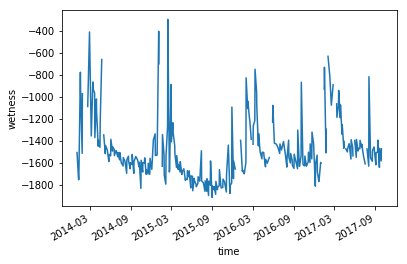

In [20]:
%matplotlib inline
plt.clf()
wetness_means = nbart_allsensors_wetness.wetness.mean(dim =('x','y'))
wetness_means.plot()
plt.show()

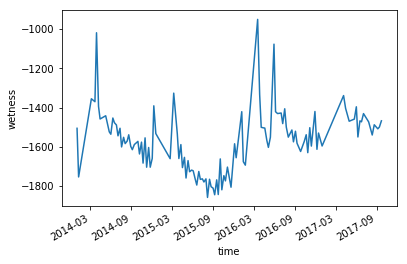

In [30]:
%matplotlib inline
plt.clf()
wetness_means = nbart_allsensors_wetness_nanfiltered.wetness.mean(dim =('x','y'))
wetness_means.plot()
plt.show()

In [ ]:
# del nbart_allsensors['red']
# del nbart_allsensors['NDVI']

### define dry seasons

In [31]:
def dry_season(month):
    '''filters on months to return a boolean mask of a dry season between may and november
    where month could be e.g. sensor3_nbart.time.dt.month'''
    return(month>=5)&(month<=10)

def dry_vals(sensor_data):
    if sensor_data is not None:
        '''calculates dry season values'''
        dry_data = sensor_data.sel(time = dry_season(sensor_data.time.dt.month))
        return dry_data
    else:
            return None 

### Linear regression code from Symington/Krause

In [32]:
#Define important functions and dictionaries
# See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = True, NDVI = False):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''

    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        # If analysing NDVI data replace negative numbers which are spurious for NDVI with nans
        if NDVI == True:
            val[val<0] = np.nan

            # Check that we have at least three values to perform our linear regression on
            if np.count_nonzero(~np.isnan(val)) > 3:
                if str(val.dims[0]) == 'month':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
                elif str(val.dims[0]) == 'year':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)
            else:
                slopes[y, x] = np.nan
                intercept = np.nan
                r_sq = np.nan
                p_values[y, x] = np.nan
        else:
            if str(val.dims[0]) == 'month':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
            elif str(val.dims[0]) == 'year':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

#### Here we select TCW from the dry seasons (as defined in the dry season functions, this can be changed)

In [36]:
dry_data = nbart_allsensors_wetness_nanfiltered.sel(time = dry_season(nbart_allsensors_wetness_nanfiltered.time.dt.month))

In [37]:
dry_wetness = dry_vals(nbart_allsensors_wetness_nanfiltered)

#### Here we plot the TCW for the epoch selected for just the dry,to get a feel for the data

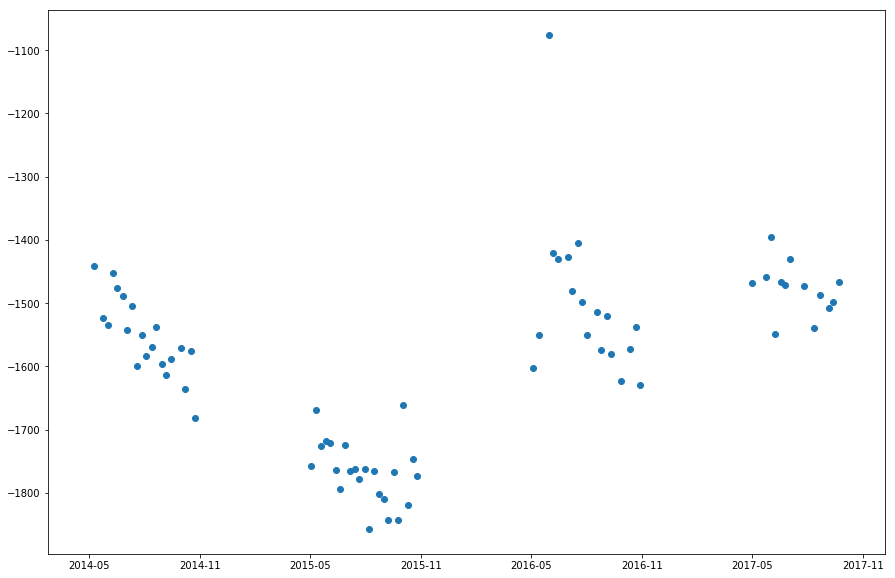

In [69]:
plt.clf()
fig = plt.figure(figsize =(15,10))
mean_dry_for_plots = dry_wetness.mean(dim =('x','y'))
plt.scatter(mean_dry_for_plots.wetness.time.data,mean_dry_for_plots.wetness)
plt.show()

##### average data - here we plot the data as an average for each month, over the epoch, to see what it looks like

In [52]:
averaged_data = dry_wetness.groupby('time.month').mean(dim='time')

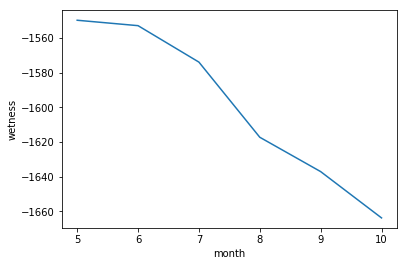

In [54]:
averaged_data.wetness.mean(dim=('x','y')).plot()
plt.show()

In [57]:
slope_xr_wet, p_val_xr_wet = linear_regression_grid(averaged_data.wetness, mask_no_trend = False, NDVI = False)

Slope shape is  (540, 493)


## Make a plot of the slope of the linear regression of the NDVI for each pixel

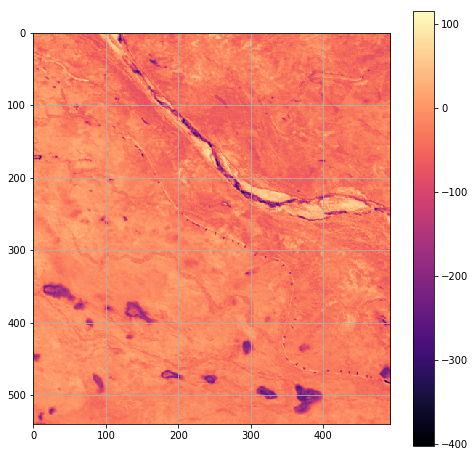

In [65]:
%matplotlib inline
plt.clf()
fig = plt.figure(figsize =(8,8))
plt.imshow(slope_xr_wet, cmap = 'magma')
plt.grid(True)
plt.colorbar()

# # #set up a file name with today's time and date in it
# write_time = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d_%H:%M:%S')
# outfilename='/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/unmasked_ndvi'+shape_name+write_time+'.png'
# plt.savefig(outfilename)

plt.show()

## Save the slope and p value of tcw to file

In [59]:
#picklefilepath = '/g/data/r78/rjd547/groundwater_activities/Mitchell/tmp/'

#### uncomment the cell below to save the variables to file and delete them from memory

In [ ]:
# pickle.dump(slope_xr_ndvi, open(picklefilepath+'slope.pkl','wb'),protocol =-1)
# pickle.dump(p_val_xr_ndvi, open(picklefilepath+'p_val.pkl','wb'),protocol =-1)
# del slope_xr_ndvi
# del p_val_xr_ndvi

## Calulate the masked slope and p val

In [66]:
slope_xr_wet_masked, p_val_xr_wet_masked = linear_regression_grid(averaged_data.wetness, mask_no_trend = True, NDVI =False)

Slope shape is  (540, 493)


## Make a plot of the slope of the linear regression of the NDVI for each pixel, but only where the p-value indicates that the slope is significant

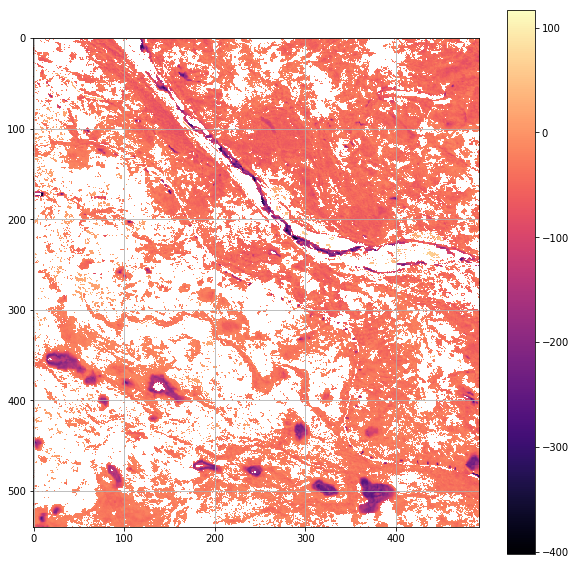

In [68]:
%matplotlib inline
plt.clf()
fig = plt.figure(figsize =(10,10))
plt.imshow(slope_xr_wet_masked, cmap = 'magma')#,vmin=-100,vmax=100)

plt.grid(True)
plt.colorbar()

# #set up a file name with today's time and date in it
# write_time = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d_%H:%M:%S')
# outfilename='/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/'+shape_name+write_time+'.png'
# plt.savefig(outfilename)

plt.show()

## Save the masked slope and p values to file as well

#### uncomment the cell below to save the variables to file and delete them from memory

In [ ]:
# pickle.dump(slope_xr_ndvi_masked, open(picklefilepath+'slope_masked.pkl','wb'),protocol =-1)
# pickle.dump(p_val_xr_ndvi_masked, open(picklefilepath+'p_val_masked.pkl','wb'),protocol =-1)
# #delete variables to save space
# del slope_xr_ndvi_masked
# del p_val_xr_ndvi_masked

___________________up to here_______________

## Manually set up an RGB image to select a pixel from which to plot a phenology plot

### select time slice of interest - this is trial and error until you get a decent image

In [97]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 32
rgb = nbart_allsensors_nanfiltered.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#fake_saturation just changes the saturation displayed, feel free to adjust as necessary
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

## Choose a location from the image below by clicking on a pixel

<IPython.core.display.Javascript object>


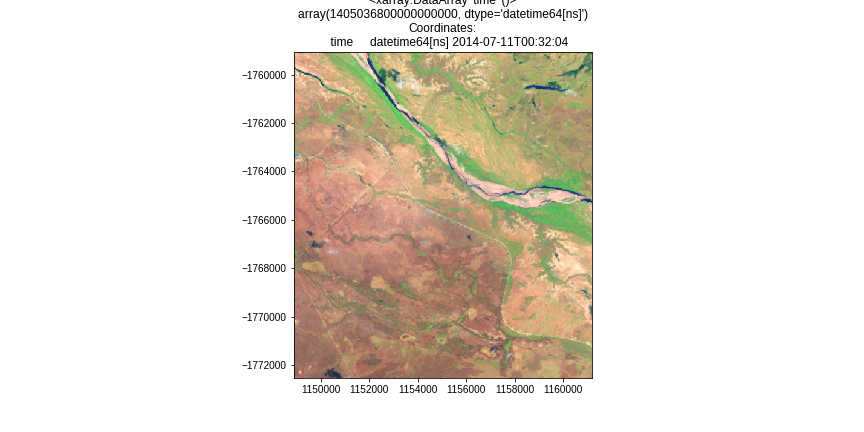

HTML(value='Event information appears here when you click on the figure')

In [98]:
%matplotlib notebook
#plt.clf()
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbart_allsensors.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [99]:
#this converts the map x coordinate into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

## Make phenology plot of TCW for chosen pixel

In [100]:
mpl.style.use('seaborn-dark')

In [104]:
nbart_allsensors_wetness_nanfiltered.wetness

<xarray.DataArray 'wetness' (time: 116, y: 540, x: 493)>
array([[[       nan,        nan, ..., -1245.4417, -1332.345 ],
        [       nan,        nan, ...,  -972.4928, -1103.5882],
        ..., 
        [-1297.628 , -1342.2606, ..., -1837.5187, -1506.7754],
        [-1346.8597, -1369.9867, ..., -1757.007 , -1699.4717]],

       [[-1734.1189, -1764.3882, ..., -1624.4326, -1416.8934],
        [-1800.5221, -1801.0757, ..., -1292.2863, -1060.9742],
        ..., 
        [-1348.351 , -1398.0457, ..., -1928.521 , -1802.2274],
        [-1382.9621, -1400.2738, ..., -1756.5327, -1838.9353]],

       ..., 
       [[-1555.219 , -1590.6803, ..., -1872.0688, -1901.5597],
        [-1566.0926, -1576.5494, ..., -1835.3455, -1767.537 ],
        ..., 
        [-1219.8712, -1253.1666, ..., -1593.5566, -1465.4435],
        [-1212.9078, -1259.6718, ..., -1466.4036, -1422.2403]],

       [[       nan,        nan, ..., -1995.4364, -2046.7423],
        [       nan,        nan, ..., -1865.6166, -1757.7432],


<IPython.core.display.Javascript object>


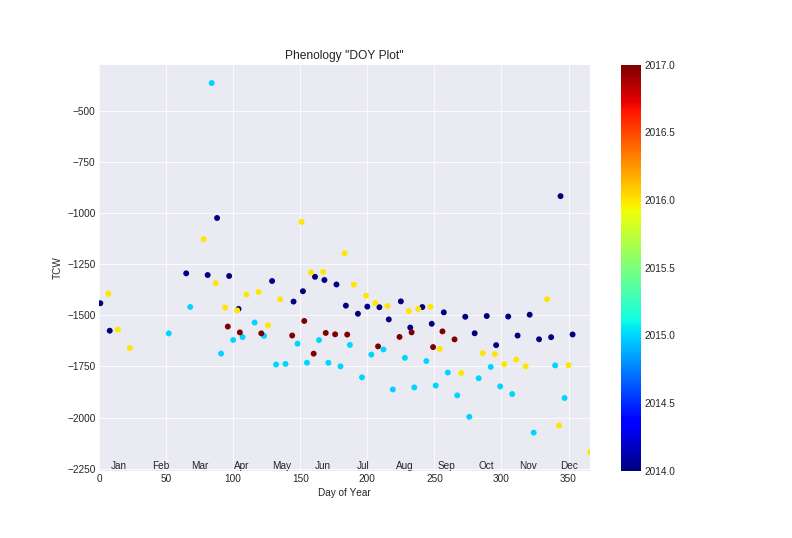

In [107]:
ts = nbart_allsensors_wetness_nanfiltered.wetness.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

mpl.style.use('seaborn-dark')

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
#ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('TCW')
ax.set_title('Phenology "DOY Plot"')
plt.savefig('Phenology_DOY_Plot.png')
#in G/ Data
plt.savefig('/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/phenology1.png')

## Make phenology plot of TCW for chosen pixel just for the chosen dry seasons

<IPython.core.display.Javascript object>


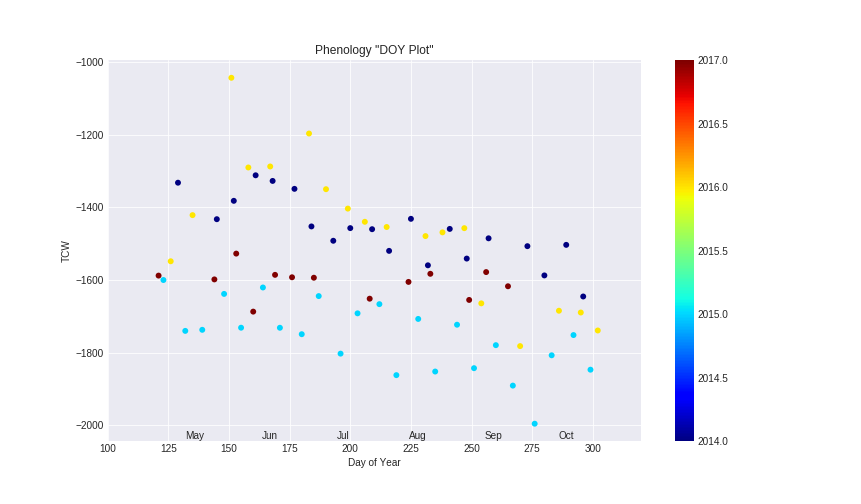

In [110]:
ts = dry_wetness.wetness.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots(figsize=(8,6))

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(5, 11)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((100, 320))
#ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('TCW')
ax.set_title('Phenology "DOY Plot"')
plt.savefig('Phenology_DOY_Plot.png')
#in G/ Data
plt.savefig('/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/phenology1.png')

## Make phenology plot of TCW for an average of the polygon for the dry seasons

#### take the spatial mean of the polygon tcw

In [114]:
sp_averaged_data = dry_wetness.wetness.mean(dim=('x','y'))

<IPython.core.display.Javascript object>


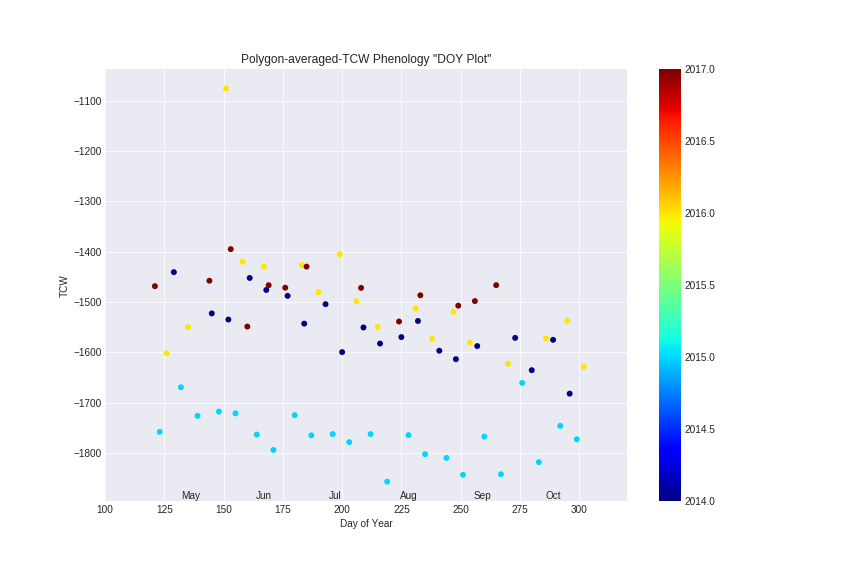

In [115]:
ts = sp_averaged_data.dropna('time', how = 'any')

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots(figsize=(8,6))

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(5, 11)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((100, 320))
#ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('TCW')
ax.set_title('Polygon-averaged-TCW Phenology "DOY Plot"')
plt.savefig('Phenology_DOY_Plot.png')
#in G/ Data
#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Mitchell/Plots/phenology1.png')

### Check that you have uncommented the lines that save the plots, and that the plots have saved.

##### Bex Dunn, Neil Symington, Vanessa Newey, Leo Lymburner Nov 2017